In [1]:
import torch
from torch.autograd import Variable
import numpy as np
print(torch.__version__) # should be the latest version 0.4.0
r = np.asarray([0.0,1.0])
print("numpy: ",r)
a = Variable(torch.from_numpy(r), requires_grad=True)
print("torch: ",a)
b = a**2
c = a + 1
d = torch.sum(c - b)
e = c/2
print("gradient" ,a.grad) # should be none
print("d", d)

0.4.0
numpy:  [0. 1.]
torch:  tensor([ 0.,  1.], dtype=torch.float64)
gradient None
d tensor(2., dtype=torch.float64)


$$d = \sum (a+1) - a^2$$

$$\frac{\partial(d)}{\partial(a_i)} = 1 - 2a_i$$

In [2]:
d.backward(retain_graph=True)
print("gradient" ,a.grad) # 1 - 2(0) = 1, 1 - 2(1) = -1

gradient tensor([ 1., -1.], dtype=torch.float64)


W = W - LR*Grad

In [3]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD([a], lr=1.0)

# in your training loop:
print(a)
optimizer.zero_grad()   # zero the gradient buffers
d.backward()
print("gradient" ,a.grad)
optimizer.step()    # Does the update
print(a)

tensor([ 0.,  1.], dtype=torch.float64)
gradient tensor([ 1., -1.], dtype=torch.float64)
tensor([-1.,  2.], dtype=torch.float64)



The Data
=====================

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

1. Loading and normalizing CIFAR10
----------------------------

Using ``torchvision``, it’s extremely easy to load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



horse   cat horse  frog


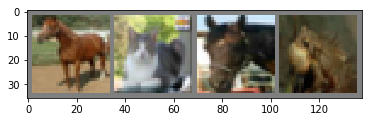

In [6]:
import matplotlib.pyplot as plt
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# how to convert back and forth from numpy arrays to torch Tensors 
images = images.numpy()
labels = labels.numpy()

images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [7]:
print(min(images.numpy().flatten()), max(images.numpy().flatten()))
print(images.numpy().shape)
#print(images) # [torch.FloatTensor of size 4x3x32x32]
#print(labels.numpy(), labels.numpy().shape)
#print(labels) #[torch.LongTensor of size 4]

-1.0 1.0
(4, 3, 32, 32)


### 2. Define a Convolution Neural Network

-  see the CNN as compression of activations and go over the conversion formula

<img src = "http://deeplearning.net/software/theano/_images/numerical_padding_strides.gif" >

here is a 3 $\times$ 3 kernel applied to a $5 \times$ 5 input padded with a 1 $\times$ 1 border of zeros using 2 $\times$ 2 strides. 

kernel weights are [[2,0,1],[1,0,0],[0,1,1]]

$$W2 = \frac{(W1 - F + 2P)}{S} + 1$$

$$\frac{(5 - 3 + 2(1))}{2} + 1 = 2 + 1 = 3$$

http://cs231n.github.io/convolutional-networks/

https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

- activation volumes / compressed images 

<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg">

- Affine Layers / Linear transformations / vanilla feed forward Neural network

<img src="http://cs231n.github.io/assets/wb.jpeg"> 

<img src="http://ufldl.stanford.edu/wiki/images/thumb/9/99/Network331.png/400px-Network331.png">

- Relu Activation

<img src = "http://laid.delanover.com/wp-content/uploads/2017/08/elu.png">

Leaky ReLUs allow a small, non-zero gradient when the unit is not active.

Parametric ReLUs take this idea further by making the coefficient of leakage into a parameter that is learned along with the other neural network parameters

$
\begin{split}\text{PReLU}(x) =
\begin{cases}
x, & \text{ if } x \geq 0 \\
ax, & \text{ otherwise }
\end{cases}\end{split}
$

Without non-linearities, DNNs would just be a linear transformation

W(Wx) = Wx

## f(W(f(Wx)))

- Max Pooling

<img src = "http://cs231n.github.io/assets/cnn/maxpool.jpeg">

## PyTorch nn.Conv2d

torch.nn only supports mini-batches. The entire `torch.nn` package only supports inputs that are a mini-batch of samples, and not a single sample.

For example, `nn.Conv2d` will take in a 4D Tensor of `nSamples x nChannels x Height x Width`.

If you have a single sample, just use `input.unsqueeze(0)` to add a fake batch dimension.

In [8]:
import torch.nn as nn

x = np.asarray([[0.0,1.0,0.0],[0.0, 0.0, 0.0]])
x = Variable(torch.from_numpy(x), requires_grad=True).unsqueeze(0).unsqueeze(0).float()
print(x)

class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=1,padding=0)

    def forward(self, x):
        
        x = self.conv(x)
        return x
    
net = Net()
z = net(x)
print(z)

print(net)

for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

tensor([[[[ 0.,  1.,  0.],
          [ 0.,  0.,  0.]]]])
tensor([[[[-0.5365,  0.2071]]]])
Net(
  (conv): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
)
conv.weight tensor([[[[ 0.2781, -0.4656],
          [ 0.2815, -0.3115]]]])
conv.bias tensor(1.00000e-02 *
       [-7.0961])


# Model architecture as a class using the PyTorch F and nn.Module 

In [9]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__() # https://stackoverflow.com/questions/222877/what-does-super-do-in-python/33469090#33469090
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=5,stride=1,padding=0)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5,stride=1,padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 64) # y = Wx+b
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        # note that the expect shape of an input is (batch_size,channels, H,W)
        x = self.pool(F.relu(self.conv1(x))) # (32 - 5)/1 + 1 = 28 , 28/2 = 14
        x = self.pool(F.relu(self.conv2(x))) # (14 - 5)/1 + 1 = 10, 10/2 = 5
        x = x.view(-1, 16 * 5 * 5) # flatten activation
        x = F.relu(self.fc1(x)) # affine
        x = F.relu(self.fc2(x)) # affine
        x = self.fc3(x) # affine 
        return x # shape = (batch_size,output_dim), [torch.FloatTensor of size 4x10] 

####### instantiate Neural Network ############

net = Net()

##############################################

### 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.

- What is a loss function?

The Loss function is a scalar, calculated from the output of your neural network and the ground truth labels, that requires the neural network to do what you want it to do in order to be minimized. This means if you change your parameters in the opposite direction of the gradient w.r.t the loss, the neural network gets better at classification.

y = label

$\hat{y}$ =  outputs

$$CE(y,\hat{y}) = - \sum_{i=1}^{C} y_i \cdot log(\hat{y}_i)$$

Where C is the number of classes, ie length of the output vector and $\hat{y}$ is the softmax probability. 

 $$softmax(o + c)_i = \frac{e^{o_i+c}}{\sum_{j} e^{o_j +c}} = \frac{e^{o_i}\cdot e^{c}}{\sum_{j} e^{o_j}\cdot e^{c}} = \frac{C \cdot e^{o_i}}{C \cdot \sum_{j} e^{o_j}} = \frac{e^{o_i}}{\sum_{j} e^{o_j}} = softmax(o)_i$$

y is a one hot encoded vector of the correct labels ("frog", 6 = [0,0,0,0,0,1,0,0,0]), lets assume that the k-th element is the only element = 1. The rest of the contributions to the cross entropy function are zeroed out from $y_i = 0$. 

We write the k-th and only contribution to the CE where $y_k = 1$ and $\hat{y}$ has been replaced by the softmax function. $\theta$, outputs, is the input to the softmax, raw class scores before they are softmax normalized. 

$\theta$ = outputs

$\hat{y}$ = softmax($\theta$). 

For one sample:

$$ CE(y,\hat{y}) = - log(\frac{e^{\theta_k}}{\sum_{i=1}^{C} e^{\theta_i} }) = log(\frac{\sum_{i=1}^{C} e^{\theta_i}}{ e^{\theta_k} }) $$
    
$$ = log(\sum_{i=1}^{C} e^{\theta_i} ) - log(e^{\theta_k}) = log(\sum_{i=1}^{C} e^{\theta_i} ) - \theta_k$$

Now the cross entropy is expressed in a form in terms of the softmax input $\theta$. We will take the derivative with respect to an arbitrary $\theta_i$ not necessarily the correct score $\theta_k$ and use the result for the individual element to see the result for the vector.

$$\frac{\partial CE}{\partial \theta_i} = \frac{\partial}{\partial \theta_i} (log(\sum_{i=1}^{C} e^{\theta_i} ) - \theta_k)  = \frac{1}{\sum_{i=1}^{C} e^{\theta_i}} \cdot e^{\theta_i} - 1[i==k]$$

The [i==k] term is a condition that means to subtract 1 only if the index of $\theta$ is the index for the correct class in which $ y_i$ = 1, ie $ y_k$. This follows from the derivative $\frac{\partial \theta_k}{\partial \theta_k} = 1$ and $\frac{\partial \theta_k}{\partial \theta_i} = 0$ . In vector form: 

$$\frac{\partial CE}{\partial \theta}  = softmax(\theta) - y $$


In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

s = np.asarray([10,10]) #np.asarray([0.5,0.5])
l = np.asarray([0])
s = Variable(torch.from_numpy(s), requires_grad=True).unsqueeze(0).float()
l = Variable(torch.from_numpy(l)) # Variable(torch.from_numpy(l), requires_grad=False).unsqueeze(0)
print(s) # scores must be variables of shape NxC, a matrix 
print(l) # labels must be variables of shape N, not Nx1, a vector, not a matrix
loss = criterion(s,l)
loss

tensor([[ 10.,  10.]])
tensor([ 0])


tensor(0.6931)

In [11]:
# how big is our dataset? 
len(trainloader)

12500

```python
loss = criterion(outputs, labels)
```

Input(outputs): (N,C) where C = number of classes

```python
Variable containing:
 0.0999  0.1114 -0.1228 -0.1509 -0.1447  0.0225 -0.0651 -0.1255  0.1152 -0.0538
 0.0997  0.1115 -0.1206 -0.1452 -0.1385  0.0162 -0.0626 -0.1249  0.1166 -0.0567
 0.0999  0.0996 -0.1172 -0.1439 -0.1498  0.0165 -0.0616 -0.1226  0.1042 -0.0651
 0.1010  0.1027 -0.1187 -0.1462 -0.1461  0.0162 -0.0634 -0.1284  0.1101 -0.0560
[torch.FloatTensor of size 4x10]
```

Target(labels): (N) where each value is 0≤targets[i]≤C−1

```python
Variable containing:
 6
 2
 9
 8
[torch.LongTensor of size 4]
```

Output: scalar = Loss

### 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

- Concept check: what do you expect the average loss to be at the start of training?

-ln(0.1) = 2.3

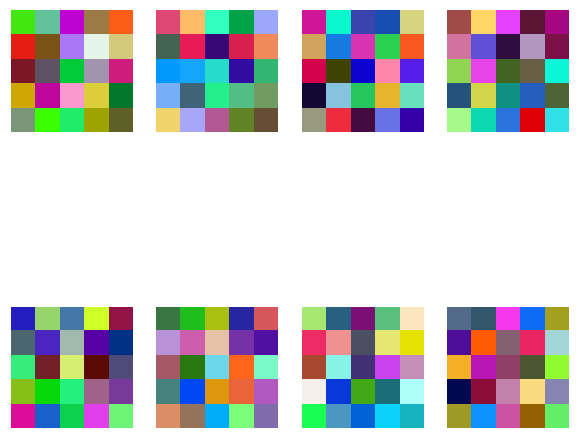

In [12]:
# dont run this cell 
# first layer filters before training , they should look random before training

mm = net.double()
filters = mm.modules
layer1 = [i for i in mm.children()][0]
tensor = layer1.weight.data.numpy()

fig = plt.figure(figsize=(10,10))
for i in range(8):
    ax1 = fig.add_subplot(2,4,i+1)
    tensor[i] = tensor[i] - min(tensor[i].flatten())
    tensor[i] = tensor[i] / max(tensor[i].flatten())
    ax1.imshow(np.transpose(tensor[i], (1, 2, 0)))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

## Training Loop

Show the random filters and the evaluation results (after the training cell) first before training, then show again after training

In [12]:
# Training Cell

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # for each epoch, sample from the dataset 
        
        # get the input normalized images and labels
        inputs, labels = data

        # wrap them in Variable so they are connected to the computational graph
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients so that this batch's gradients are not added to previous batch's
        optimizer.zero_grad()

        # forward + backward + optimize: ALOT happens here in just 4 short lines of code 
        outputs = net(inputs) # forward pass
        #print(outputs)
        #print(labels)
        #break
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() # backward pass to calculate gradients
        optimizer.step() # apply gradients to all parameters

        
        running_loss += loss.data[0] # add all losses together so they can be averaged at print time
        
        # print statistics
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,  2000] loss: 2.158
[1,  4000] loss: 1.845
[1,  6000] loss: 1.687
[1,  8000] loss: 1.586
[1, 10000] loss: 1.532
[1, 12000] loss: 1.500
[2,  2000] loss: 1.409
[2,  4000] loss: 1.373
[2,  6000] loss: 1.357
[2,  8000] loss: 1.332
[2, 10000] loss: 1.309
[2, 12000] loss: 1.268
[3,  2000] loss: 1.239
[3,  4000] loss: 1.213
[3,  6000] loss: 1.211
[3,  8000] loss: 1.206
[3, 10000] loss: 1.166
[3, 12000] loss: 1.169
[4,  2000] loss: 1.102
[4,  4000] loss: 1.126
[4,  6000] loss: 1.126
[4,  8000] loss: 1.124
[4, 10000] loss: 1.100
[4, 12000] loss: 1.091
[5,  2000] loss: 1.033
[5,  4000] loss: 1.049
[5,  6000] loss: 1.054
[5,  8000] loss: 1.041
[5, 10000] loss: 1.057
[5, 12000] loss: 1.040
Finished Training


### 5. Test the network on the test data

We have trained the network for 5 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


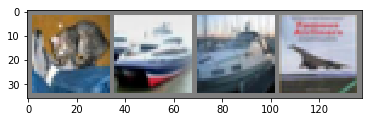

In [13]:
# the right answers
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [14]:
# what our network thinks
outputs = net(Variable(images))
outputs

tensor([[-0.4602, -2.9341,  0.7712,  3.1372,  0.0559,  3.1865,  0.1174,
         -0.3713, -0.9940, -1.6799],
        [ 4.0004,  7.2506, -2.5849, -3.5252, -3.5262, -5.0609, -4.4425,
         -3.1956,  4.3191,  4.2016],
        [ 1.6949,  1.9847, -0.9312, -1.1193, -0.7672, -1.9709, -2.3201,
         -1.7989,  3.4498,  1.6197],
        [ 4.4054, -0.4274, -0.0780, -1.5923,  0.3300, -2.6361, -3.3885,
         -1.9651,  4.0294,  0.9341]])

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [15]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   car  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [16]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [18]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in testloader:
    images, labels = data
    #outputs = net(Variable(images).double())
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze().int()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

In [19]:
class_total[0]

for i in range(10):
    
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 77 %
Accuracy of  bird : 43 %
Accuracy of   cat : 37 %
Accuracy of  deer : 51 %
Accuracy of   dog : 56 %
Accuracy of  frog : 67 %
Accuracy of horse : 64 %
Accuracy of  ship : 76 %
Accuracy of truck : 77 %


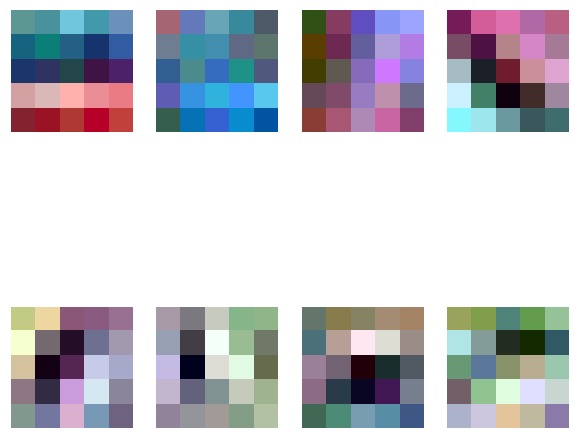

In [20]:
mm = net.double()
filters = mm.modules
layer1 = [i for i in mm.children()][0]
tensor = layer1.weight.data.numpy()

fig = plt.figure(figsize=(10,10))
for i in range(8):
    ax1 = fig.add_subplot(2,4,i+1)
    tensor[i] = tensor[i] - min(tensor[i].flatten())
    tensor[i] = tensor[i] / max(tensor[i].flatten())
    ax1.imshow(np.transpose(tensor[i], (1, 2, 0)))
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.
This will recursively go over all modules and convert their parameters and
buffers to CUDA tensors:


        net.cuda()


Remember that you will have to send the inputs and targets at every step
to the GPU too:


        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.


**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




In [1]:
def im2col(x,hh,ww,stride):

    """
    Args:
      x: image matrix to be translated into columns, (C,H,W)
      hh: filter height
      ww: filter width
      stride: stride
    Returns:
      col: (new_h*new_w,hh*ww*C) matrix, each column is a cube that will convolve with a filter
            new_h = (H-hh) // stride + 1, new_w = (W-ww) // stride + 1
    """

    c,h,w = x.shape
    new_h = (h-hh) // stride + 1
    new_w = (w-ww) // stride + 1
    col = np.zeros([new_h*new_w,c*hh*ww])

    for i in range(new_h):
       for j in range(new_w):
           patch = x[...,i*stride:i*stride+hh,j*stride:j*stride+ww]
           col[i*new_w+j,:] = np.reshape(patch,-1)
    return col

In [58]:
import numpy as np
x = np.random.randint(2, size=12).reshape(1,3,4)
xcol = im2col(x,2,2,1)
x = np.squeeze(x)
x

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 1, 0, 0]])

In [59]:
#im2col(x,3,3,1)
# filter size = 3 x 3, stride = 1
ker = np.array([
                 [1., -1.],
                 [1., -1.],
                ])

In [60]:
from scipy.signal import convolve2d

### WRITE CODE IN HERE , you can have up to 2 cells for this question but only one is required ######

convolve2d(x, ker, 'valid')

array([[ 2., -2.,  0.],
       [ 1., -2.,  0.]])

In [61]:
xcol

array([[0., 1., 0., 1.],
       [1., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 1., 1., 1.],
       [1., 0., 1., 0.],
       [0., 0., 0., 0.]])

In [71]:
ker_flat = np.flip(ker.flatten(),axis=0)
np.flip(ker_flat,axis=0)

array([ 1., -1.,  1., -1.])

In [69]:
out = xcol.dot(ker_flat)
out

array([ 2., -2.,  0.,  1., -2.,  0.])

In [47]:
def col2im(mul,h_prime,w_prime,C):
    """
      Args:
      mul: (h_prime*w_prime*w,F) matrix, each col should be reshaped to C*h_prime*w_prime when C>0, or h_prime*w_prime when C = 0
      h_prime: reshaped filter height
      w_prime: reshaped filter width
      C: reshaped filter channel, if 0, reshape the filter to 2D, Otherwise reshape it to 3D
    Returns:
      if C == 0: (F,h_prime,w_prime) matrix
      Otherwise: (F,C,h_prime,w_prime) matrix
    """
    F = mul.shape[1]
    if(C == 1):
        out = np.zeros([F,h_prime,w_prime])
        for i in range(F):
            col = mul[:,i]
            out[i,:,:] = np.reshape(col,(h_prime,w_prime))
    else:
        out = np.zeros([F,C,h_prime,w_prime])
        for i in range(F):
            col = mul[:,i]
            out[i,:,:] = np.reshape(col,(C,h_prime,w_prime))

    return out

IndexError: tuple index out of range